In [1]:
import array
from deap import base, creator, tools, algorithms, benchmarks
import numpy as np
import random
from matplotlib import cm
import matplotlib.pyplot as plt

### A estratégia de evolução é um algoritmo de otimização global estocástico
### Ele é um algoritmo evolutivo relacionado a outros, como o algoritmo genético, embora seja projetado especificamente para otimização contínua da função.
#### Ao contrário de alguns algoritmos evolutivos, ele não usa cruzamento, ele limita a modificação de soluções a operações de mutação.

#### A população é inicialmente gerada aleatoriamente. Cada iteração do algoritmo envolve primeiro avaliar a população de soluções e, em seguida, excluir todas, exceto um subconjunto das melhores soluções, referidas como seleção de truncamento.
####  As soluções restantes (os pais) são usadas como base para gerar uma série de novas soluções (mutação) que substituem ou competem com os pais por uma posição na população para consideração na próxima iteração do algoritmo (geração).

##### Uma separação mais (+) dos parâmetros mu e lambda indica que as crianças e os pais juntos definirão a população para a próxima iteração.
##### (mu + lambda)-ES: Uma versão das estratégias de evolução em que crianças e pais são adicionados à população.
#### Um algoritmo estocástico de escalada pode ser implementado como uma Estratégia de Evolução e teria a notação (1 + 1)-ES.

In [11]:
# O tamanho da população é referido como lambda e o número de pais selecionados em cada iteração é referido como mu.
# O número de filhos criados a partir de cada pai é calculado como (lambda / mu) e os parâmetros devem ser escolhidos 
# para que a divisão não tenha resto.
# Permite que os pais compitam com as crianças pela seleção na próxima iteração do algoritmo.

# mu: O número de pais selecionou cada iteração.
# lambda: Tamanho da população.
# lambda / mu: Número de filhos gerados a partir de cada pai selecionado.

random.seed(42)
# Como foi pedido na atividade, roda o algoritmo no modelo de esfera.
current_problem = benchmarks.sphere

In [33]:
def plot_problem_3d(problem, bounds, resolution=100., 
                    cmap=cm.viridis_r, rstride=10, cstride=10, 
                    linewidth=0.15, alpha=0.65, ax=None):
    'Plots a given deap benchmark problem in 3D mesh.'
    (minx,miny),(maxx,maxy) = bounds
    x_range = np.arange(minx, maxx, (maxx-minx)/resolution)
    y_range = np.arange(miny, maxy, (maxy-miny)/resolution)
    
    X, Y = np.meshgrid(x_range, y_range)
    Z = np.zeros((len(x_range), len(y_range)))
    
    for i in range(len(x_range)):
        for j in range(len(y_range)):
            Z[i,j] = problem((x_range[i], y_range[j]))[0]
    
    if not ax:
        fig = plt.figure(figsize=(11,6))
        ax = fig.gca(projection='3d')
        
    cset = ax.plot_surface(X, Y, Z, cmap=cmap, rstride=rstride, cstride=cstride, linewidth=linewidth, alpha=alpha)

In [34]:
def plot_problem_controur(problem, bounds, optimum=None,
                          resolution=100., cmap=cm.viridis_r, 
                          rstride=1, cstride=10, linewidth=0.15,
                          alpha=0.65, ax=None):
    'Plots a given deap benchmark problem as a countour plot'
    (minx,miny),(maxx,maxy) = bounds
    x_range = np.arange(minx, maxx, (maxx-minx)/resolution)
    y_range = np.arange(miny, maxy, (maxy-miny)/resolution)
    
    X, Y = np.meshgrid(x_range, y_range)
    Z = np.zeros((len(x_range), len(y_range)))
    
    for i in range(len(x_range)):
        for j in range(len(y_range)):
            Z[i,j] = problem((x_range[i], y_range[j]))[0]
    
    if not ax:
        fig = plt.figure(figsize=(6,6))
        ax = fig.gca()
        ax.set_aspect('equal')
        ax.autoscale(tight=True)
    
    cset = ax.contourf(X, Y, Z, cmap=cmap, rstride=rstride, cstride=cstride, linewidth=linewidth, alpha=alpha)
    
    if optimum:
        ax.plot(optimum[0], optimum[1], 'bx', linewidth=4, markersize=15)

In [35]:
def plot_cov_ellipse(pos, cov, volume=.99, ax=None, fc='lightblue', ec='darkblue', alpha=1, lw=1):
    ''' Plots an ellipse that corresponds to a bivariate normal distribution.
    Adapted from http://www.nhsilbert.net/source/2014/06/bivariate-normal-ellipse-plotting-in-python/'''
    from scipy.stats import chi2
    from matplotlib.patches import Ellipse

    def eigsorted(cov):
        vals, vecs = np.linalg.eigh(cov)
        order = vals.argsort()[::-1]
        return vals[order], vecs[:,order]

    if ax is None:
        ax = plt.gca()

    vals, vecs = eigsorted(cov)
    theta = np.degrees(np.arctan2(*vecs[:,0][::-1]))

    kwrg = {'facecolor':fc, 'edgecolor':ec, 'alpha':alpha, 'linewidth':lw}

    # Width and height are "full" widths, not radius
    width, height = 2 * np.sqrt(chi2.ppf(volume,2)) * np.sqrt(vals)
    ellip = Ellipse(xy=pos, width=width, height=height, angle=theta, **kwrg)
    ax.add_artist(ellip)

In [2]:
search_space_dims = 2 # Plotar indivíduos, por isso 2...

MIN_VALUE, MAX_VALUE = -10., 10.
MIN_STRAT, MAX_STRAT = 0.0000001, 1.

In [3]:
# Problema de minimização
creator.create("FitnessMin", base.Fitness, weights=(-1.0,))

# Estratégias evolucionárias precisão de um local (mean)
creator.create("Individual", array.array, typecode='d', 
               fitness=creator.FitnessMin, strategy=None)
# Um valor para o parâmetro estratégia.
creator.create("Strategy", array.array, typecode="d")

In [4]:
# inicializa a estratégia de avaliação do indivíduo
def init_es_ind(individual_class, strategy_class,
                           size, min_value, max_value, 
                           min_strat, max_strat):
    ind = individual_class(random.uniform(min_value, max_value) 
                           for _ in range(size))
    # Modifica a instância para incluir a estratégia em run-time.
    ind.strategy = strategy_class(random.uniform(min_strat, max_strat) for _ in range(size))
    return ind

In [5]:
toolbox = base.Toolbox() 
toolbox.register("individual", init_es_ind, 
                 creator.Individual, 
                 creator.Strategy,
                 search_space_dims, 
                 MIN_VALUE, MAX_VALUE, 
                 MIN_STRAT, MAX_STRAT)
toolbox.register("population", tools.initRepeat, list, 
                 toolbox.individual)

In [6]:
ind = toolbox.individual()
pop = toolbox.population(n=100)

In [7]:
def plot_individual(individual, ax=None):
    'Plots an ES indiviual as center and 3*sigma ellipsis.'
    cov = np.eye(len(individual)) * individual.strategy
    plot_cov_ellipse(individual, cov, volume=0.99, alpha=0.56, ax=ax)
    if ax:
        ax.scatter(individual[0], individual[1], 
                    marker='+', color='k', zorder=100)
    else:
        plt.scatter(individual[0], individual[1], 
                    marker='+', color='k', zorder=100)

    
def plot_population(pop, gen=None, max_gen=None, ax=None):
    if gen:
        plt.subplot(max_gen, 1, gen)
        
    for ind in pop:
        plot_individual(ind, ax)

In [8]:
toolbox.register("mutate", tools.mutGaussian, mu=0, sigma=1, indpb=0.2)

In [9]:
toolbox.register("mate", tools.cxTwoPoint)
toolbox.register("evaluate", current_problem)
toolbox.register("select", tools.selTournament, tournsize=3)

NameError: name 'current_problem' is not defined

In [46]:
n=100

pop = toolbox.population(n=n)
hof = tools.HallOfFame(1)

# lambda é a quantidade de indíviduos que serão selecionados para reprodução.
# Quanto melhor o fitness maior a probabilidade de seleção.
# Pode acontecer de um indivíduo ser selecionado mais de uma vez.
# O valor de mu é o número de indivíduos que serão selecionados para reprodução.
# Se caso em uma mutação o resultado forem muito ruins, eles reaproveitam o resultado dos pais.

pop_stats = tools.Statistics(lambda ind: ind.fitness.values)
pop_stats.register("avg", np.mean)
pop_stats.register("std", np.std)
pop_stats.register("min", np.min)
pop_stats.register("max", np.max)
    
pop, logbook = algorithms.eaMuPlusLambda(pop, toolbox, mu=n, lambda_=n, 
        cxpb=0.6, mutpb=0.3, ngen=40, stats=pop_stats, halloffame=hof)

gen	nevals	avg    	std    	min     	max    
0  	10    	54.5356	41.8836	0.382848	108.342
1  	10    	10.7   	23.6494	0.382848	81.3168
2  	9     	1.87169	2.33689	0.382848	8.10753
3  	10    	0.284056	0.080663	0.218195	0.382848
4  	9     	0.251126	0.065861	0.218195	0.382848
5  	9     	0.218195	0       	0.218195	0.218195
6  	9     	0.203238	0.0299146	0.143408	0.218195
7  	9     	0.203238	0.0299146	0.143408	0.218195
8  	8     	0.18828 	0.0366378	0.143408	0.218195
9  	9     	0.158366	0.0299146	0.143408	0.218195
10 	8     	0.143408	2.77556e-17	0.143408	0.143408
11 	10    	0.143408	2.77556e-17	0.143408	0.143408
12 	10    	0.143408	2.77556e-17	0.143408	0.143408
13 	10    	0.143408	2.77556e-17	0.143408	0.143408
14 	9     	0.143408	2.77556e-17	0.143408	0.143408
15 	9     	0.143408	2.77556e-17	0.143408	0.143408
16 	10    	0.143408	2.77556e-17	0.143408	0.143408
17 	8     	0.143408	2.77556e-17	0.143408	0.143408
18 	10    	0.143408	2.77556e-17	0.143408	0.143408
19 	10    	0.143408	2.77556e-17	0.143408	

<ipython-input-34-87099329b85c>:23: UserWarning: The following kwargs were not used by contour: 'rstride', 'cstride', 'linewidth'
  cset = ax.contourf(X, Y, Z, cmap=cmap, rstride=rstride, cstride=cstride, linewidth=linewidth, alpha=alpha)


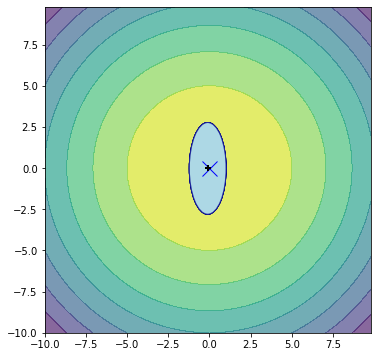

In [47]:
plot_problem_controur(current_problem, ((-10,-10), (10,10)), optimum=(0,0))
plot_population(pop)

In [62]:
n=100

pop = toolbox.population(n=n)
hof = tools.HallOfFame(1)

pop_stats = tools.Statistics(lambda ind: ind.fitness.values)
pop_stats.register("avg", np.mean)
pop_stats.register("std", np.std)
pop_stats.register("min", np.min)
pop_stats.register("max", np.max)
    
pop, logbook = algorithms.eaMuPlusLambda(pop, toolbox, mu=n, lambda_=n, 
        cxpb=0.6, mutpb=0.3, ngen=40, stats=pop_stats, halloffame=hof)

gen	nevals	avg    	std    	min     	max    
0  	100   	61.5868	40.7929	0.697124	153.742
1  	88    	27.7236	21.814 	1.17502 	110.264
2  	90    	10.842 	9.21868	0.746995	56.9522
3  	92    	4.76716	3.47022	0.746995	20.0558
4  	95    	2.36858	1.20392	0.422322	5.23476
5  	95    	1.37737	0.896435	0.190421	3.11221
6  	91    	0.733613	0.420885	0.190421	2.85161
7  	94    	0.419778	0.265102	0.0631205	0.850044
8  	92    	0.19677 	0.161355	0.0631205	0.850044
9  	89    	0.0963107	0.0551627	0.0631205	0.190421
10 	95    	0.0635806	0.0158695	0.000705537	0.190421
11 	91    	0.0592312	0.0143366	0.000705537	0.0631205
12 	90    	0.0497286	0.0235066	0.000705537	0.0631205
13 	94    	0.0421779	0.0270235	0.000705537	0.0631205
14 	92    	0.025508 	0.0267818	0.000705537	0.0631205
15 	88    	0.00663002	0.0105012	0.000705537	0.0631205
16 	89    	0.0024205 	0.00228832	0.000705537	0.00955629
17 	86    	0.0012413 	0.00122758	0.000705537	0.00405402
18 	96    	0.000705537	1.0842e-19	0.000705537	0.000705537
19 	90    	

<ipython-input-34-87099329b85c>:23: UserWarning: The following kwargs were not used by contour: 'rstride', 'cstride', 'linewidth'
  cset = ax.contourf(X, Y, Z, cmap=cmap, rstride=rstride, cstride=cstride, linewidth=linewidth, alpha=alpha)


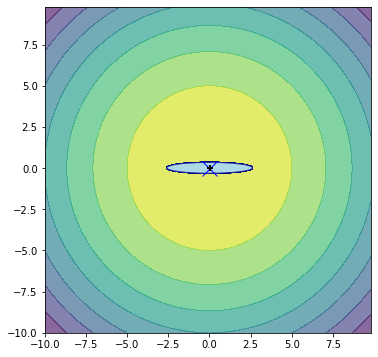

In [63]:
plot_problem_controur(current_problem, ((-10,-10), (10,10)), optimum=(0,0))
plot_population(pop)

In [64]:
n=500

pop = toolbox.population(n=n)
hof = tools.HallOfFame(1)

pop_stats = tools.Statistics(lambda ind: ind.fitness.values)
pop_stats.register("avg", np.mean)
pop_stats.register("std", np.std)
pop_stats.register("min", np.min)
pop_stats.register("max", np.max)
    
pop, logbook = algorithms.eaMuPlusLambda(pop, toolbox, mu=n, lambda_=n, 
        cxpb=0.6, mutpb=0.3, ngen=40, stats=pop_stats, halloffame=hof)

gen	nevals	avg    	std    	min     	max    
0  	500   	68.6996	42.7201	0.167804	194.884
1  	441   	32.5327	26.1828	0.167804	145.52 
2  	461   	12.5907	13.4743	0.165045	105.602
3  	444   	3.75661	4.73778	0.00678164	31.7955
4  	449   	1.00378	1.17638	0.00678164	9.3143 
5  	444   	0.334662	0.29779	0.00678164	1.92024
6  	455   	0.134696	0.10517	0.00678164	0.607821
7  	453   	0.0576483	0.0559525	0.000399988	0.279104
8  	450   	0.0198021	0.0292485	0.000399988	0.149616
9  	452   	0.00661421	0.00338313	0.000399988	0.039898
10 	442   	0.00545075	0.00235645	0.000399988	0.00678164
11 	466   	0.00382694	0.0056107 	0.000399988	0.110878  
12 	459   	0.00140666	0.00202799	0.000399988	0.00678164
13 	455   	0.000477913	0.000631177	0.000399988	0.00678164
14 	450   	0.000396697	3.27474e-05	7.08643e-05	0.000399988
15 	453   	0.000393378	4.6268e-05 	6.4111e-05 	0.000399988
16 	447   	0.000377527	8.31583e-05	6.4111e-05 	0.000399988
17 	443   	0.000382787	0.000980867	6.4111e-05 	0.0221081  
18 	451   	0.0005

<ipython-input-34-87099329b85c>:23: UserWarning: The following kwargs were not used by contour: 'rstride', 'cstride', 'linewidth'
  cset = ax.contourf(X, Y, Z, cmap=cmap, rstride=rstride, cstride=cstride, linewidth=linewidth, alpha=alpha)


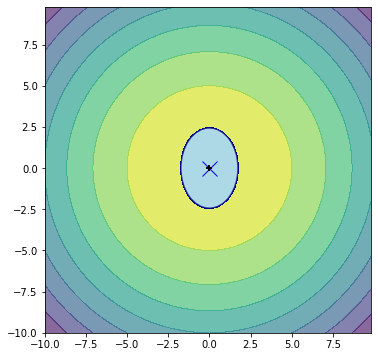

In [65]:
plot_problem_controur(current_problem, ((-10,-10), (10,10)), optimum=(0,0))
plot_population(pop)

In [66]:
n=1000

pop = toolbox.population(n=n)
hof = tools.HallOfFame(1)

pop_stats = tools.Statistics(lambda ind: ind.fitness.values)
pop_stats.register("avg", np.mean)
pop_stats.register("std", np.std)
pop_stats.register("min", np.min)
pop_stats.register("max", np.max)
    
pop, logbook = algorithms.eaMuPlusLambda(pop, toolbox, mu=n, lambda_=n, 
        cxpb=0.6, mutpb=0.3, ngen=40, stats=pop_stats, halloffame=hof)

gen	nevals	avg    	std    	min     	max    
0  	1000  	66.6842	43.9629	0.164154	197.039
1  	904   	31.0183	24.3986	0.164154	123.389
2  	904   	12.6713	11.4943	0.0851002	77.5929
3  	889   	4.64483	4.58064	0.0851002	27.9252
4  	904   	1.58825	1.53165	0.00289353	10.7985
5  	904   	0.522981	0.502433	0.00289353	3.65981
6  	903   	0.222983	0.172081	0.00289353	1.55046
7  	888   	0.115564	0.0743024	0.00151637	0.46143
8  	900   	0.0570586	0.0442341	0.00151637	0.380667
9  	902   	0.0223478	0.0239419	9.67956e-05	0.164076
10 	894   	0.00758508	0.00672364	9.67956e-05	0.0730449
11 	917   	0.00334649	0.00266513	9.67956e-05	0.0174308
12 	890   	0.0021077 	0.00103061	9.67956e-05	0.00938351
13 	898   	0.00129113	0.000818833	9.67956e-05	0.00307819
14 	901   	0.000712356	0.000443331	8.1872e-05 	0.00289353
15 	909   	0.000399382	0.000380284	8.1872e-05 	0.00289353
16 	891   	0.000150369	0.000187439	8.1872e-05 	0.000894087
17 	910   	9.84504e-05	4.10739e-05	4.15697e-05	0.000894087
18 	905   	9.49987e-05	7.11

<ipython-input-34-87099329b85c>:23: UserWarning: The following kwargs were not used by contour: 'rstride', 'cstride', 'linewidth'
  cset = ax.contourf(X, Y, Z, cmap=cmap, rstride=rstride, cstride=cstride, linewidth=linewidth, alpha=alpha)


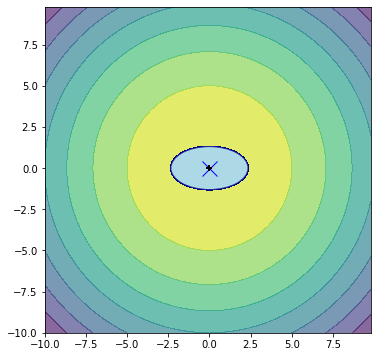

In [67]:
plot_problem_controur(current_problem, ((-10,-10), (10,10)), optimum=(0,0))
plot_population(pop)

In [68]:
n=5000

pop = toolbox.population(n=n)
hof = tools.HallOfFame(1)

pop_stats = tools.Statistics(lambda ind: ind.fitness.values)
pop_stats.register("avg", np.mean)
pop_stats.register("std", np.std)
pop_stats.register("min", np.min)
pop_stats.register("max", np.max)
    
pop, logbook = algorithms.eaMuPlusLambda(pop, toolbox, mu=n, lambda_=n, 
        cxpb=0.6, mutpb=0.3, ngen=40, stats=pop_stats, halloffame=hof)

gen	nevals	avg    	std    	min       	max    
0  	5000  	68.2857	41.5705	0.00101717	198.447
1  	4527  	33.263 	24.8771	0.0194511 	151.033
2  	4522  	13.5341	11.7924	0.0104171 	89.1556
3  	4543  	5.01198	4.81547	0.00052661	44.4287
4  	4523  	1.64193	1.69204	0.00052661	14.4276
5  	4510  	0.539554	0.56539	0.000259693	4.53938
6  	4519  	0.178341	0.197713	0.000259693	2.80107
7  	4505  	0.0563976	0.0620687	9.28369e-05	0.717437
8  	4512  	0.0202031	0.0228175	1.28132e-05	0.668105
9  	4512  	0.00744242	0.00685905	1.28132e-05	0.0748164
10 	4469  	0.00281329	0.00287448	1.04272e-05	0.0223827
11 	4496  	0.000935502	0.00104252	1.04272e-05	0.00956376
12 	4493  	0.000692612	0.024273  	6.25014e-06	1.71675   
13 	4511  	0.000167701	0.000327966	6.25014e-06	0.0202171 
14 	4504  	8.20356e-05	6.49981e-05	5.16612e-06	0.000425387
15 	4475  	5.93835e-05	0.00181199 	5.16612e-06	0.128146   
16 	4481  	1.64973e-05	9.71197e-05	3.04725e-06	0.00685505 
17 	4546  	1.04813e-05	4.21033e-06	1.89413e-07	9.28369e-05
18 	4

<ipython-input-34-87099329b85c>:23: UserWarning: The following kwargs were not used by contour: 'rstride', 'cstride', 'linewidth'
  cset = ax.contourf(X, Y, Z, cmap=cmap, rstride=rstride, cstride=cstride, linewidth=linewidth, alpha=alpha)


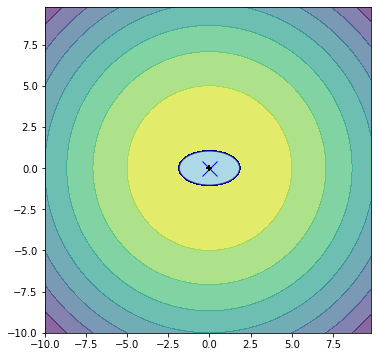

In [69]:
plot_problem_controur(current_problem, ((-10,-10), (10,10)), optimum=(0,0))
plot_population(pop)